# Setup

In [1]:
import pandas as pd
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import seaborn as sns

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 18

plt.style.use('fivethirtyeight')


# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=400):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


PROCESSED_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets/processed")
def save_processed(df, filename, extension="csv"):
    if not os.path.isdir(PROCESSED_PATH):
        os.makedirs(PROCESSED_PATH)
    path = os.path.join(PROCESSED_PATH, filename + "." + extension)
    print("Saving processed dataset", filename)
    df.to_csv(path, index=False)
    
# if less than R1K, show as R800 (for eg). If btw R1000 and R999,999, show as R1K or R999K. If R1,000,000 or greater, show as R1M
def currency_formatter(x, pos):
    if x >= 1000000:
        return 'R%1.1fM' % (x * 1e-6)
    elif x < 1000:
        return 'R%1.1d' % (x)
    else:
        return 'R%1.1dK' % (x * 1e-3) 
    
axes_formatter = FuncFormatter(currency_formatter) 

# Download & Process Zomato Data

In [2]:
API_KEY = "REPLACE_KEY"
ENTITY_TYPE = "city"
SORT_BY = "rating"
SORT_ORDER = ["desc", "asc"]
RAW_FOLDER = "datasets/raw/"
PROCESSED_FOLDER = "datasets/processed/"

In [3]:
def load_data(base_path, file, sub_dir=None, ext="csv", encoding=None):
    filename = file + "." + ext
    if sub_dir is not None:
        csv_path = os.path.join(base_path, sub_dir, filename)
    else:
        csv_path = os.path.join(base_path, filename)
    return pd.read_csv(csv_path)

In [8]:
city_ids = load_data(RAW_FOLDER, "zomato_city_ids")
city_ids.head()

,Country,City,Zomato ID
0,South Africa,Cape Town,64


In [495]:
import requests
import json

def get_categories():
    # Get all zomato categories.
    # Categories are global and not unique to a specific country.
    headers = {"user-key": API_KEY}
    response=requests.get("https://developers.zomato.com/api/v2.1/categories", headers=headers)
    json_data = response.json()
    
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)
    file_name = "categories.json"
    file_path = os.path.join(RAW_FOLDER, file_name)
    
    with open(file_path, 'w') as outfile:
        json.dump(json_data, outfile)
        
    # return all the category id's for restaurant search function.  
    cat_ids = [category["categories"]["id"] for category in json_data["categories"]]
    return cat_ids
        
def get_establishment_type_for_city(city_id):
    # Finding all establishment types in city_id and writing to file
    headers = {"user-key": API_KEY}
    params = {"city_id": city_id}
    response=requests.get("https://developers.zomato.com/api/v2.1/establishments", 
                          headers=headers, params=params)
    json_data = response.json()
       
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)    
    file_name = "establishment_types_" + str(city_id) + "." + "json"
    file_path = os.path.join(RAW_FOLDER, file_name)
    
    with open(file_path, 'w') as outfile:
        json.dump(json_data, outfile)
        
    # return all the establishment type id's for restaurant search function.  
    establishment_ids = [establishment["establishment"]["id"] for establishment in json_data["establishments"]]
    return establishment_ids
        
def get_cuisine_type_for_city(city_id):
    # Finding all cuisine types in Cape Town and writing to file
    headers = {"user-key": API_KEY}
    params = {"city_id": city_id}
    response=requests.get("https://developers.zomato.com/api/v2.1/cuisines", 
                          headers=headers, params=params)
    json_data = response.json()
    
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)    
    file_name = "cuisine_types_" + str(city_id) + "." + "json"
    file_path = os.path.join(RAW_FOLDER, file_name)
    
    with open(file_path, 'w') as outfile:
        json.dump(json_data, outfile)
        
    # return all the cuisine type id's for restaurant search function.
    cuisine_ids = [cuisine["cuisine"]["cuisine_id"] for cuisine in json_data["cuisines"]]
    return cuisine_ids

In [496]:
def download_with_criteria(headers, city_id, file_path, iterable_list, iterable_name, sort_order, is_item_list=False):
    json_dump = []
    
    # if API is not expecting a list for iterable_name, then run through each value as as search criteria
    if not is_item_list:        
        for item in iterable_list:
            start = 0
            results_shown = 20
            while results_shown != 0:                
                params = {"entity_id": city_id, "entity_type": ENTITY_TYPE, "start": start, 
                          "count": 20, iterable_name: item,"sort": SORT_BY, 
                          "order": sort_order}
                response=requests.get("https://developers.zomato.com/api/v2.1/search", 
                                  headers=headers, params=params)

                json_data = response.json()
                results_shown = int(json_data.get("results_shown", 0))

                if results_shown == 0:
                    break

                # appending each dictionary to a list so that json.load() can process 
                # multiple dictionaries
                json_dump.append(json.dumps(json_data))     

                start += 20
    
    # otherwise pass the full list to iterable_name, such as cuisine's. 
    # note: initially it was attempted to run through the above loop for every cuisine type, but allowed API calls 
    # where exceeded for a single city download attempt. 
    else:
        start = 0
        results_shown = 20
        while results_shown != 0:            
            params = {"entity_id": city_id, "entity_type": ENTITY_TYPE, "start": start, 
                      "count": 20, iterable_name: iterable_list,"sort": SORT_BY, 
                      "order": sort_order}
            response=requests.get("https://developers.zomato.com/api/v2.1/search", 
                              headers=headers, params=params)

            json_data = response.json()
            results_shown = int(json_data.get("results_shown", 0))

            if results_shown == 0:
                break

            # appending each dictionary to a list so that json.load() can process 
            # multiple dictionaries
            json_dump.append(json.dumps(json_data))     

            start += 20
        
            
    
    # each dictionary must exist as a list object for json.load to read it correctly    
    with open(file_path, 'w') as outfile:
        outfile.write("[")
        count = 0
        for item in json_dump:
            outfile.write(item)
            if count < len(json_dump)-1:
                outfile.write(",")
            count += 1
        outfile.write("]")

In [497]:
def get_restaurants(city_id, establishment_types):
     # Find 100 top rated restaurants of each establishment type, category and cuisine type per city and write to file
    headers = {"user-key": API_KEY}
    
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)
    
    search_criteria = ["Category", "Establishment Type", "Cuisine Type"]
    city_name = city_ids[city_ids["Zomato ID"] == city_id]["City"].values[0]

    # Download restaurant for city by establishment type
    print("Downloading restaurants for", city_name, "by", search_criteria[1])
    
    for sort_order in SORT_ORDER:
        file_name = "restaurants_by_establishment_type_" + str(city_id) + "_" + sort_order + "." + "json"
        file_path = os.path.join(RAW_FOLDER, file_name)
        download_with_criteria(headers, city_id, file_path, establishment_types, "establishment_type", 
                               sort_order, is_item_list=False)
    print("Done")

In [498]:
for city_id in city_ids["Zomato ID"]:
    establishments = get_establishment_type_for_city(city_id)
    get_restaurants(city_id, establishments)

KeyboardInterrupt: 

In [ ]:
# For each city, we need to combine the restaurant data from the categories-based, establishment type-based and cuisine-based json files. 

def build_csv(city_id, source_type):
    restaurants_list = []
    for sort_order in SORT_ORDER:
        file_name = "restaurants_by_" + source_type + "_" + str(city_id) + "_" + sort_order + ".json"
        source_path = os.path.join(RAW_FOLDER, file_name)

        db = json.load(open(source_path))

        restaurant_cols = ["name", 
                           "cuisines",
                           "aggregate_rating", 
                           "rating_text", 
                           "votes",
                           "currency", 
                           "average_cost_for_two", 
                           "price_range",                    
                           "locality",
                           "locality_verbose",
                           "city", 
                           "zipcode",
                           "country_id",
                           "latitude", 
                           "longitude",                                       
                           "has_online_delivery", 
                           "has_table_booking", 
                           ]

        restaurants = [restaurant_group["restaurant"] for count_group in db 
                           for restaurant_group in count_group["restaurants"]] 

        for restaurant in restaurants:
            restaurant["locality"] = restaurant["location"]["locality"]
            restaurant["locality_verbose"] = restaurant["location"]["locality_verbose"]
            restaurant["city"] = restaurant["location"]["city"]
            restaurant["latitude"] = restaurant["location"]["latitude"]
            restaurant["longitude"] = restaurant["location"]["longitude"]
            restaurant["zipcode"] = restaurant["location"]["zipcode"]
            restaurant["country_id"] = restaurant["location"]["country_id"]
            restaurant["aggregate_rating"] = restaurant["user_rating"]["aggregate_rating"]
            restaurant["votes"] = restaurant["user_rating"]["votes"]
            restaurant["rating_text"] = restaurant["user_rating"]["rating_text"]
            
        restaurants_list.append(restaurants)
        
    df1 = pd.DataFrame(restaurants_list[0], columns=restaurant_cols)
    df2 = pd.DataFrame(restaurants_list[1], columns=restaurant_cols)
    return pd.concat([df1, df2])
    

def process_restaurants_json(city_id):
    
    source_types = ["establishment_type"]
    dfs = []
    for source in source_types:
        dfs.append(build_csv(city_id, source))
    
    if not os.path.isdir(PROCESSED_FOLDER):
         os.makedirs(PROCESSED_FOLDER) 
    
    file_name = "restaurants_" + str(city_id) + ".csv"
    output_path = os.path.join(PROCESSED_FOLDER, file_name)

    data = pd.concat(dfs)
    data.to_csv(output_path, encoding='utf-8-sig', index=False)
    

In [ ]:
for city in city_ids["Zomato ID"]:
    process_restaurants_json(city)

# Data Preparation

In [4]:
data = load_data(PROCESSED_FOLDER, 'restaurants_64')
data.shape

(1970, 17)

In [5]:
data.head()

,name,cuisines,aggregate_rating,rating_text,votes,currency,average_cost_for_two,price_range,locality,locality_verbose,city,zipcode,country_id,latitude,longitude,has_online_delivery,has_table_booking
0,Moro Gelato,"Desserts, Ice Cream",4.8,Excellent,72,R,80,1,CBD,"CBD, Cape Town",Cape Town,NaN,189,-33.924108,18.417317,0,0
1,Unframed Ice Cream,Ice Cream,4.7,Excellent,104,R,40,1,Gardens,"Gardens, Cape Town",Cape Town,NaN,189,-33.928691,18.412097,0,0
2,The Velvet Cake Co.,"Bakery, Desserts",4.6,Excellent,90,R,165,2,CBD,"CBD, Cape Town",Cape Town,NaN,189,-33.919300,18.421512,0,0
3,The Creamery,"Desserts, Ice Cream",4.5,Excellent,389,R,110,2,Newlands,"Newlands, Cape Town",Cape Town,NaN,189,-33.970286,18.461950,0,0
4,My Sugar,"Cafe, Patisserie, Bakery, Desserts",4.5,Excellent,197,R,125,2,Sea Point,"Sea Point, Cape Town",Cape Town,NaN,189,-33.921692,18.382759,0,0


## Remove Duplicates

Since we downloaded the top 100 and bottom 100 restuarants of each category, there is likely to be some duplication as certain categories contain less than 200 restaurants meaning that the same establishment could appear near the bottom of the top 100 or the top of the bottom 100. There are many restaurant franchises in Cape Town, so we'll define a duplicate as a restaurant with the same name at the same locality.

In [6]:
data[data.duplicated(subset=["name", "locality"])]

,name,cuisines,aggregate_rating,rating_text,votes,currency,average_cost_for_two,price_range,locality,locality_verbose,city,zipcode,country_id,latitude,longitude,has_online_delivery,has_table_booking
87,N' Ice,"Ice Cream, Desserts",0.0,Not rated,1,R,70,1,Strand,"Strand, Cape Town",Cape Town,NaN,189,-34.114265,18.822527,0,0
156,Vida E Caffe,"Cafe, Desserts",3.3,Average,17,R,150,2,Gardens,"Gardens, Cape Town",Cape Town,NaN,189,-33.929000,18.411833,0,0
162,Kauai,"Healthy Food, Fast Food",3.3,Average,11,R,200,3,CBD,"CBD, Cape Town",Cape Town,NaN,189,-33.922833,18.420833,0,0
299,The Fat Cactus,"Mexican, Finger Food, Tex-Mex",4.1,Very Good,420,R,300,4,Gardens,"Gardens, Cape Town",Cape Town,NaN,189,-33.928833,18.410833,0,0
301,Rick's Cafe Americain,"Moroccan, Grill, Seafood, Burger, Finger Food",3.9,Good,273,R,320,4,Gardens,"Gardens, Cape Town",Cape Town,NaN,189,-33.928372,18.410481,0,0
302,Beerhouse on Long,"Grill, German",3.9,Good,305,R,300,4,CBD,"CBD, Cape Town",Cape Town,8001.0,189,-33.925512,18.415936,0,0
303,Bombay Bicycle Club,"Mediterranean, Steak, Finger Food",3.9,Good,279,R,450,4,Gardens,"Gardens, Cape Town",Cape Town,NaN,189,-33.936626,18.404738,0,0
500,Warwick Wine Estate,"South African, Mediterranean, Cafe",4.6,Excellent,104,R,440,4,Stellenbosch,"Stellenbosch, Cape Town",Cape Town,NaN,189,-33.840835,18.864158,0,0
502,My Sugar,"Cafe, Patisserie, Bakery, Desserts",4.5,Excellent,197,R,125,2,Sea Point,"Sea Point, Cape Town",Cape Town,NaN,189,-33.921692,18.382759,0,0
503,The Velvet Cake Co.,"Cafe, Desserts, Bakery",4.4,Very Good,130,R,160,2,Bellville,"Bellville, Cape Town",Cape Town,NaN,189,-33.868301,18.641180,0,0


In [7]:
data.duplicated(subset=["name", "locality"]).sum()

614

In [8]:
# duplicates are considerd those restaurants with the same name in the same location. Keep the first instance.
data = data.drop_duplicates(subset=["name", "locality"], keep='first')
data.shape

(1356, 17)

## Removing Unneccessary Columns

In [9]:
#removing currency, country, locality_verbose and zipcode
cols = ['name', 'cuisines', 'aggregate_rating', 'rating_text', 'votes',
       'average_cost_for_two', 'price_range', 'locality', 'city',
       'latitude', 'longitude', 'has_online_delivery', 'has_table_booking']
data = data[cols]
data.head()

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking
0,Moro Gelato,"Desserts, Ice Cream",4.8,Excellent,72,80,1,CBD,Cape Town,-33.924108,18.417317,0,0
1,Unframed Ice Cream,Ice Cream,4.7,Excellent,104,40,1,Gardens,Cape Town,-33.928691,18.412097,0,0
2,The Velvet Cake Co.,"Bakery, Desserts",4.6,Excellent,90,165,2,CBD,Cape Town,-33.919300,18.421512,0,0
3,The Creamery,"Desserts, Ice Cream",4.5,Excellent,389,110,2,Newlands,Cape Town,-33.970286,18.461950,0,0
4,My Sugar,"Cafe, Patisserie, Bakery, Desserts",4.5,Excellent,197,125,2,Sea Point,Cape Town,-33.921692,18.382759,0,0


## Fix Restaurants with Missing Geographic Info

We'll also identify restaurants that don't have their latitude and longitude specified as we'll be using these parameters during the analysis. Where possible, we'll fill in these values by looking up the restaurant info on Google Maps. If we can't find the info, we'll remove the restaurant from the analysis. 

In [10]:
data[(data["longitude"] == 0) & (data["latitude"] == 0)]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking
41,Jessy's Waffles,Desserts,3.2,Average,11,100,2,Gardens,Cape Town,0.0,0.0,0,0
91,DV Café,"Desserts, Cafe, Ice Cream",0.0,Not rated,0,50,1,"Spice Route Farm, Paarl",Cape Town,0.0,0.0,0,0
130,Vida E Caffe,"Cafe, Desserts",3.5,Good,17,150,2,Camps Bay,Cape Town,0.0,0.0,0,0
134,Lekker Vegan,Fast Food,3.4,Average,28,200,3,CBD,Cape Town,0.0,0.0,0,0
361,The Vic Bar,"American, Italian",3.0,Average,6,0,1,Gardens,Cape Town,0.0,0.0,0,0
641,Ben's On the Beach,"Grill, Burger",3.6,Good,58,320,4,Strand,Cape Town,0.0,0.0,0,0
774,La Bella Rosa Bistro & Coffee,"Cafe, Burger, Bakery",2.8,Average,4,160,2,Durbanville,Cape Town,0.0,0.0,0,0
826,The Common Room,Finger Food,0.0,Not rated,0,70,1,CBD,Cape Town,0.0,0.0,0,0
937,Jack Rabbit Mobile Kitchen,"Fast Food, Street Food, South African",0.0,Not rated,3,100,2,Durbanville,Cape Town,0.0,0.0,0,0
1431,Moyo,African,3.4,Average,86,561,4,Newlands,Cape Town,0.0,0.0,0,0


In [11]:
data.loc[41, "latitude"] = -33.9314912; data.loc[41, "longitude"] = 18.416589
data.loc[91, "latitude"] = -33.7643602; data.loc[91, "longitude"] = 18.9180991
data.loc[130, "latitude"] = -33.9511; data.loc[130, "longitude"] = 18.3763713
data.loc[134, "latitude"] = -33.9284282; data.loc[134, "longitude"] = 18.4215289
data.loc[361, "latitude"] = -33.9330936; data.loc[361, "longitude"] = 18.4058024
data.loc[641, "latitude"] = -34.1115314; data.loc[641, "longitude"] = 18.819894
data.loc[774, "latitude"] = -33.833121; data.loc[774, "longitude"] = 18.6438816
data.loc[826, "latitude"] = -33.926449; data.loc[826, "longitude"] = 18.4454532
data.loc[1431, "latitude"] = -33.988727; data.loc[1431, "longitude"] = 18.4313973
data.loc[1540, "latitude"] = -33.9036187; data.loc[1540, "longitude"] = 18.4183216
data.loc[1663, "latitude"] = -33.9358607; data.loc[1663, "longitude"] = 18.8564851

In [12]:
data[(data["longitude"] == 0) & (data["latitude"] == 0)]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking
937,Jack Rabbit Mobile Kitchen,"Fast Food, Street Food, South African",0.0,Not rated,3,100,2,Durbanville,Cape Town,0.0,0.0,0,0


The only restaurant we couldn't find location information for was Jack Rabbit Mobile Kitchen. This makes sense since it sounds like a food truck that doesn't have a fixed location. We'll remove it.

In [13]:
data = data[(data["longitude"] != 0) & (data["latitude"] != 0)]
data[(data["longitude"] == 0) & (data["latitude"] == 0)]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking


We know these are South African restaurants, so all their latitude values should be negative and all their longitude values positive, let's check this.

In [14]:
data[data["latitude"] > 0]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking
643,The 41,"Contemporary, Seafood, Mediterranean, Sushi",3.5,Good,29,400,4,Camps Bay,Cape Town,33.948688,18.376794,0,0
685,Pearl Mountain,Drinks Only,3.3,Average,7,50,1,"Pearl Mountain Wine Estate, Paarl",Cape Town,33.702186,18.995174,0,0
868,Groot Constantia Winery,Drinks Only,3.9,Good,52,90,1,"Groot Constantia Wine Estate, Constantia",Cape Town,34.026732,18.422542,0,0
1665,Anura Tasting Room,Drinks Only,3.1,Average,5,100,2,Anura,Cape Town,33.804110,18.884110,0,0
1841,The Trading Post Eatery,"Cafe, Deli",3.0,Average,5,200,3,Anura,Cape Town,33.811946,18.885821,0,0


In [15]:
f = lambda x: -x if x > 0 else x
data.latitude = data.latitude.apply(f)
data[data["latitude"] > 0]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking


In [16]:
data[data["longitude"] < 0]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking


## Add Dummy Columns for Each Cuisine Type

We'd like to have a true/false value for each cuisine type. This will make it easier to count restaurants by specific cuisine types later. Zomato piles all the cuisines together in a single comma seperated field, so we need to break this up first and then create dummies.

In [17]:
# Values in cuisine columns may have multiple values with ',' seperator
# Extract each possible cuisine type then ensure each dummy column is prefixed with "cuisine_"

dummies = data['cuisines'].str.get_dummies(sep=", ")
dummies.columns = [str(col) for col in dummies.columns]
data = pd.concat([data, dummies], axis=1)
print(data.shape)
data.sample(10)

(1355, 86)


,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,Steak,Street Food,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese
49,Marcel's Frozen Yoghurt,Desserts,3.1,Average,5,100,2,"Bayside Mall, Table View",Cape Town,-33.823610,...,0,0,0,0,0,0,0,0,0,0
1404,Riempies - Southern Sun Cape Sun,"European, Cape Malay",3.1,Average,7,519,4,CBD,Cape Town,-33.921756,...,0,0,0,0,0,0,0,0,0,0
504,New York Bagels,"Cafe, Bakery, Deli, Coffee and Tea, Sandwich",4.4,Very Good,139,150,2,Zonnebloem,Cape Town,-33.928421,...,0,0,0,0,0,0,0,0,0,0
1418,The Famous Butcher's Grill - Cape Town Lodge,Steak,3.3,Average,52,498,4,CBD,Cape Town,-33.922319,...,1,0,0,0,0,0,0,0,0,0
1130,McDonalds,Fast Food,2.5,Average,7,100,2,"Tyger Manor, Bellville",Cape Town,-33.876109,...,0,0,0,0,0,0,0,0,0,0
753,Rosa's Bakery,"Cafe, Bakery",3.2,Average,9,200,3,CBD,Cape Town,-33.921750,...,0,0,0,0,0,0,0,0,0,0
250,Cafe Manhattan,"American, Grill",4.1,Very Good,106,300,4,Green Point,Cape Town,-33.916199,...,0,0,0,0,0,0,0,0,0,0
1141,Anat,"Lebanese, Fast Food",2.6,Average,13,120,2,"Victoria Wharf, V & A Waterfront",Cape Town,-33.904333,...,0,0,0,0,0,0,0,0,0,0
686,Val Du Charron Wine & Olive Estate,Drinks Only,3.3,Average,9,80,1,Wellington,Cape Town,-33.624601,...,0,0,0,0,0,0,0,0,0,0
651,Steam Restaurant,"Burger, Tapas, South African, Grill, Steak",3.4,Average,44,300,4,Stellenbosch,Cape Town,-33.938209,...,1,0,0,1,0,0,0,0,0,0


## Extract a Place of Interest from Locality and Store in New Column
Some restaurants are part of a place of interest such as a shopping mall or hotel. This is specified in the locality as a comma-seperated pair. We'll split these out into their own column and use "None" where it doesn't apply. This allows us to investigate rating trends at specific shopping malls, for example.

In [18]:
# Go through each row and extract a place value from the locality if one is specified
# Store the place and locality seperately in order to filter more precisely

places = []
localities = []
def split_locality(row):
    items = row["locality"].split(',')
    if len(items) > 1:
        places.append(items[0])
        localities.append(items[1].strip())
    else:
        places.append("None")
        localities.append(items[0].strip())
        
       
data.apply(split_locality, axis=1)
data["places"] = places
data["locality"] = localities

In [19]:
data[["locality", "places"]].sample(10)

,locality,places
1389,V & A Waterfront,None
564,Camps Bay,None
493,CBD,None
300,Pinelands,None
1164,Bellville,None
1262,Durbanville,None
1617,De Waterkant,None
443,Camps Bay,None
164,Table View,None
325,Hermanus,None


## Fix Localities Incorrectly Entered Into Zomato
A number of localities were found with spelling mistakes leading to an incorrect representation of the data. While we could exclude these I would rather try fix them manually so as to keep as much data as possible for the analysis.

In [20]:
mapping = {
    "Dubanville": "Durbanville",
    "Contantia": "Constantia",
    "Tableview": "Table View",
    "Belville":"Bellville",
    "Belvile":"Bellville",
    "Bellvile":"Bellville",
    "Bay Area": "Kalk Bay",
    "Gordon's Bay": "Gordons Bay",
    "V&A Waterfront":"V & A Waterfront",
    "The Woodstock Exchange. Woodstock": "Woodstock",
    "Franschoek":"Franschhoek",
    "Somersetwest":"Somerset West",
    "Kuilsriver":"Kuils River",
    "Greenpoint":"Green Point",
    "Ridgeback Wine Farm": "Ridgeback Wine Farm, Paarl",
    "Anura": "Anura, Stellenbosch",
    "Hannover": "Hanover Park",
    "NH The Lord Charles Hotel": "NH The Lord Charles Hotel, Somerset West",
    "Fairbridge Mall": "Fairbridge Mall, Brackenfell",
    "Blouberg": "Bloubergstrand",
    "Two Oceans Beach": "Two Oceans Beach, Mouille Point",
    "Neelsie Student Centre": "Neelsie Student Centre, Stellenbosch"
}

def correct_incorrect_localities(col):
    if col in mapping:
        return mapping.get(col, 'None')
    else:
        return col
    
# If no mapping provided, return x
f = lambda x: mapping.get(x, x)
data.locality = data.locality.map(f)

# split locality and places again after corrections.
places = []
localities = []

def split_locality(row):
    items = row["locality"].split(',')
    if len(items) > 1:
        places.append(items[0])
        localities.append(items[1].strip())
    else:
        places.append(row["places"])
        localities.append(row["locality"])
        
data.apply(split_locality, axis=1)
data["places"] = places
data["locality"] = localities

In [21]:
data[data.places == "NH The Lord Charles Hotel"]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,Street Food,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese,places
1405,The Garden Terrace - NH The Lord Charles,"European, Contemporary, Italian",3.1,Average,4,460,4,Somerset West,Cape Town,-34.06657,...,0,0,0,0,0,0,0,0,0,NH The Lord Charles Hotel
1406,La Vigna - NH The Lord Charles,"Seafood, Burger, Beverages, Contemporary, Dess...",3.1,Average,6,450,4,Somerset West,Cape Town,-34.06657,...,0,0,0,0,0,0,0,0,0,NH The Lord Charles Hotel


In [22]:
data[data.places == "Neelsie Student Centre"]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,Street Food,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese,places
943,Vlambojant,"Beverages, Fast Food",0.0,Not rated,1,100,2,Stellenbosch,Cape Town,-33.932627,...,0,0,0,0,0,0,0,0,0,Neelsie Student Centre


In [23]:
idx = data[data.locality.str.contains('Kalk', regex=False)].index
data.loc[idx, "places"] = "None"

In [24]:
data[data.locality.str.contains('Kalk', regex=False)]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,Street Food,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese,places
15,The Ice Cafe,Desserts,3.7,Good,41,45,1,Kalk Bay,Cape Town,-34.126000,...,0,0,0,0,0,0,0,0,0,None
108,Kalkys,"Seafood, Fish and Chips, Fast Food",3.8,Good,167,180,2,Kalk Bay,Cape Town,-34.129317,...,0,0,0,0,0,0,0,0,0,None
127,Lucky Fish & Chips,"Fast Food, Seafood",3.5,Good,24,150,2,Kalk Bay,Cape Town,-34.129317,...,0,0,0,0,0,0,0,0,0,None
424,Harbour House Restaurant,"Seafood, Sushi",4.1,Very Good,160,500,4,Kalk Bay,Cape Town,-34.129281,...,0,1,0,0,0,0,0,0,0,None
480,Live Bait,"Seafood, Sushi, European",3.7,Good,76,500,4,Kalk Bay,Cape Town,-34.132044,...,0,1,0,0,0,0,0,0,0,None
529,Olympia Cafe & Deli,"Cafe, Deli",4.0,Very Good,162,200,3,Kalk Bay,Cape Town,-34.127530,...,0,0,0,0,0,0,0,0,0,None
586,Lekker,"Cafe, South African, European",3.7,Good,75,250,3,Kalk Bay,Cape Town,-34.126930,...,0,0,0,0,0,0,0,0,0,None


## Build Web Scraper & Add Region Column to Visualise Larger Geographical Areas

In addition to the locality/suburb, we'd like to visualise larger regional trends as well. To do this, we'll scrape a list of Cape Town suburbs and their associated regions from https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs. 

We'll export the suburb/region match to its own data file, then for each restaurant in our dataset, we will match its locality to this list of suburbs and assign the fitting region to a new column in the main dataset.

In [25]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

response = requests.get('https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs')
content = response.content
parser = BeautifulSoup(content, 'html.parser')

#Finding all regions in th Wiki page - these have the .mw-headline class
regions_list = [region.text for region in parser.select(".mw-headline")]
suburbs_by_region = {}                    

# The .wikitable class is assigned to each table of suburbs per region    
regions = parser.select(".wikitable")  

count = 0
for region in regions:
    # Finding each suburb while skipping columns with postal codes
    # Some fields have additional info in (), so splitting on those and removing
    suburbs = [suburb.text.split('(')[0] for suburb in region.select("td")[::3]]
    
    for suburb in suburbs:
        suburbs_by_region[suburb] = regions_list[count]
    count += 1  
 
# We need to manually add entries which are known suburbs of the greater Cape Town area
df = pd.DataFrame(list(suburbs_by_region.items()), columns=['locality', 'region'])
df.to_csv("datasets/processed/cape-town-suburbs.csv", encoding='utf-8-sig', index=False)

In [26]:
suburbs = pd.read_csv("datasets/processed/cape-town-suburbs.csv")
suburbs.sample(10)

,locality,region
51,Constantia,Southern Suburbs
12,Vredehoek,City Bowl
46,Sea Point,Atlantic Seaboard
0,Bo-Kaap,City Bowl
35,Rugby,Northern Suburbs
30,Milnerton,West Coast
124,Melkbosstrand,West Coast
33,Parow,Northern Suburbs
78,Glencairn,South Peninsula
75,Capri Village,South Peninsula


In [27]:
def match_locality(row):
    suburb = suburbs[suburbs['locality'] == row['locality']]
    if suburb.shape[0] == 1:
        return suburb.iloc[0]['region']
    else:
        return "None"

data["region"] = data.apply(match_locality, axis=1)
data.head(10)

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese,places,region
0,Moro Gelato,"Desserts, Ice Cream",4.8,Excellent,72,80,1,CBD,Cape Town,-33.924108,...,0,0,0,0,0,0,0,0,None,None
1,Unframed Ice Cream,Ice Cream,4.7,Excellent,104,40,1,Gardens,Cape Town,-33.928691,...,0,0,0,0,0,0,0,0,None,City Bowl
2,The Velvet Cake Co.,"Bakery, Desserts",4.6,Excellent,90,165,2,CBD,Cape Town,-33.919300,...,0,0,0,0,0,0,0,0,None,None
3,The Creamery,"Desserts, Ice Cream",4.5,Excellent,389,110,2,Newlands,Cape Town,-33.970286,...,0,0,0,0,0,0,0,0,None,Southern Suburbs
4,My Sugar,"Cafe, Patisserie, Bakery, Desserts",4.5,Excellent,197,125,2,Sea Point,Cape Town,-33.921692,...,0,0,0,0,0,0,0,0,None,Atlantic Seaboard
5,The Velvet Cake Co.,"Cafe, Desserts, Bakery",4.4,Very Good,130,160,2,Bellville,Cape Town,-33.868301,...,0,0,0,0,0,0,0,0,None,Northern Suburbs
6,The Creamery,"Desserts, Ice Cream",4.2,Very Good,110,110,2,Green Point,Cape Town,-33.904093,...,0,0,0,0,0,0,0,0,None,Atlantic Seaboard
7,Myog,Desserts,4.1,Very Good,87,100,2,Gardens,Cape Town,-33.931500,...,0,0,0,0,0,0,0,0,None,City Bowl
8,The Creamery,"Desserts, Ice Cream",4.1,Very Good,45,75,1,Claremont,Cape Town,-33.981278,...,0,0,0,0,0,0,0,0,None,Southern Suburbs
9,DV Artisan Chocolate,Desserts,3.9,Good,24,70,1,Paarl,Cape Town,-33.760864,...,0,0,0,0,0,0,0,0,Spice Route Farm,None


In [28]:
# We need to manually add suburbs that are part of the wider Cape Town region including Winelands etc.
# We could exclude these entries from the analysis but we'd then be excluding areas such as Stellenbosch and Franshoek which are know food mecca's in Cape Town.

mapping = {
    "CBD":"City Bowl",
    "Century City":"Northern Suburbs",
    "Paarl":"Winelands",
    "Stellenbosch":"Winelands",
    "V & A Waterfront":"Atlantic Seaboard",
    "Kalk Bay":"South Peninsula",
    "Franschhoek": "Winelands",
    "Riebeek Kasteel":"West Coast",
    "Gordons Bay":"Helderberg",
    "Hermanus":"Overberg",
    "Robertson":"Winelands",
    "Wellington":"Winelands",
    "Woodstock": "City Bowl",
    "Noordhoek":"South Peninsula",
    "Worcester":"Winelands",
    "Zonnebloem": "City Bowl",
    "Rylands":"Cape Flats",
    "Malmesbury": "West Coast",
    "Darling": "West Coast",
    "Sunningdale":"Northern Suburbs",
    "Cape Town International Airport":"Northern Suburbs",
    "Scarborough": "South Peninsula"
}


def map_locality_to_region(row):
    if row['region'] == 'None':
        return mapping.get(row['locality'], 'None')
    else:
        return row['region']
    

data["region"] = data.apply(map_locality_to_region, axis=1)
data[data["region"] == "None"]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese,places,region
464,Two Oceans Restaurant,Seafood,3.8,Good,54,570,4,Cape Point,Cape Town,-34.356368,...,0,0,0,0,0,0,0,0,None,None


In [29]:
data = data.drop(data.index[data["region"] == "None"].tolist())
data[data["region"] == "None"]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese,places,region


In [30]:
data.sample(50)

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese,places,region
916,Sansibar,"American, European",3.6,Good,22,300,4,Stellenbosch,Cape Town,-33.943500,...,0,0,0,0,0,0,0,0,Asara Wine Estate,Winelands
398,Wild Clover Restaurant & Bar,"Indian, Healthy Food, Burger, Cape Malay, Gril...",2.6,Average,21,450,4,Stellenbosch,Cape Town,-33.847888,...,0,0,0,0,0,0,0,0,None,Winelands
431,ON19 Restaurant - The Westin Cape Town,"African, Continental",4.1,Very Good,45,460,4,Foreshore,Cape Town,-33.915730,...,0,0,0,0,0,0,0,0,The Westin,City Bowl
1883,Beyerskloof Tasting Room,Drinks Only,3.2,Average,9,50,1,Stellenbosch,Cape Town,-33.891173,...,0,0,0,0,0,0,0,0,Beyerskloof Wine Estate,Winelands
408,De Grendel Restaurant and Wine Estate,"European, South African",4.3,Very Good,129,480,4,Plattekloof,Cape Town,-33.851066,...,0,0,0,0,0,0,0,0,None,Northern Suburbs
706,Crew Bar,Drinks Only,2.8,Average,5,200,3,Green Point,Cape Town,-33.914862,...,0,0,0,0,0,0,0,0,None,Atlantic Seaboard
793,The Gourmet Bakery,Bakery,0.0,Not rated,1,50,1,V & A Waterfront,Cape Town,-33.905400,...,0,0,0,0,0,0,0,0,V & A Foodmarket,Atlantic Seaboard
526,Scheckter's RAW,"Cafe, Healthy Food",4.0,Very Good,116,160,2,Sea Point,Cape Town,-33.922243,...,0,0,0,0,0,0,0,0,None,Atlantic Seaboard
984,Moody Lagoon,"Contemporary, French",3.1,Average,5,800,4,Hermanus,Cape Town,-34.345714,...,0,0,0,0,0,0,0,0,None,Overberg
59,Addictions,"Desserts, Ice Cream",2.9,Average,2,120,2,Hout Bay,Cape Town,-34.042666,...,0,0,0,0,0,0,0,0,Mainstream Shopping Centre,Atlantic Seaboard


Let's dive deeper and see if we can spot cuisine trends within specific suburbs. We'll look for the top 10 and bottom 10 

## Add Column to Store The Count of Cuisines Types Offered

In [31]:
def get_cuisine_cols():
    cols = ["name", "aggregate_rating", "rating_text", "votes", "average_cost_for_two", "price_range", "cuisines", "cuisine_count", "places", "locality", "region", "city", "latitude", "longitude", "has_online_delivery", "has_table_booking", "top_bottom"]
    '''Returns the column names of all the cuisine type column, not including the cuisine_count column'''
    cuisine_cols = [col for col in data.columns.tolist() if col not in cols]
    return cuisine_cols   

def count_cuisines(row):
    #count = len([col for col in data.columns if 'cuisine_' in col if row[col] == True]) 
    count = len([col for col in data.columns.tolist() if col in get_cuisine_cols() if row[col] == True]) 
    return count

data["cuisine_count"] = data.apply(count_cuisines, axis=1)
data.sample(5)

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese,places,region,cuisine_count
131,Kauai,"Cafe, Healthy Food, Cafe",3.4,Average,63,220,3,Century City,Cape Town,-33.892667,...,0,0,0,0,0,0,0,Canal Walk Mall,Northern Suburbs,2
622,Vrede en Lust Winery,Drinks Only,3.7,Good,28,50,1,Paarl,Cape Town,-33.837423,...,0,0,0,0,0,0,0,None,Winelands,1
1570,The Farmyard Farmstall,Cafe,2.9,Average,12,195,2,Melkbosstrand,Cape Town,-33.735475,...,0,0,0,0,0,0,0,None,West Coast,1
170,Snoekies,"Fast Food, Seafood",3.2,Average,47,140,2,Hout Bay,Cape Town,-34.051104,...,0,0,0,0,0,0,0,None,Atlantic Seaboard,2
1648,DeMorgenzon,Drinks Only,3.0,Average,4,100,2,Stellenbosch,Cape Town,-33.942500,...,0,0,0,0,0,0,0,None,Winelands,1


In [32]:
data[["cuisines", "cuisine_count"]].sample(10)

,cuisines,cuisine_count
376,Finger Food,1
1434,"European, South African",2
743,"Cafe, Bakery",2
1919,Drinks Only,1
1085,"Cafe, Healthy Food",2
587,"Cafe, Deli",2
415,"Italian, Grill",2
136,"Fish and Chips, Fast Food",2
345,"Finger Food, Burger, Steak, Grill",4
264,"French, Mediterranean, Seafood, Grill",4


## Adding Place Type identifier based on Parsed Locality Field

Some of our localities were listed in Zomato as a comma-seperated value. This implied that the location was a place of interest such as a mall or hotel which contains multiple restaurants. We already seperated this into `places` and `locality` fields, now we'd like to further identify the place by type such as `Hotel`, `Wine Estate` etc. so that we can further filter and visualise this data.

In order to obtain these values, a manual google search will be done to properly classify the place type.

In [33]:
places_type_mapping = {
    "12 Apostles Hotel & Spa" : "Hotel",
    "African Pride 15 on Orange Hotel" : "Hotel",
    "Alphen 5 Star Boutique Hotel" : "Hotel",
    "Asara Wine Estate" : "Wine",
    "Ashley Cooper House" : "Mall",
    "Avondale Wines" : "Wine",
    "Babylonstoren Wine Estate" : "Wine",
    "Bayside Mall" : "Mall",
    "Bayside on Fish Hoek Beach" : "Mall",
    "Beau Constantia Wine Estate" : "Wine",
    "Beyerskloof Wine Estate" : "Wine",
    "Bloemendal Wine Farm" : "Wine",
    "Blue Route Mall" : "Mall",
    "Boschendal Estate" : "Wine",
    "Canal Walk Mall" : "Mall",
    "Cape Quarter Lifestyle Center" : "Mall",
    "Capegate Shopping Center" : "Mall",
    "Cavendish Square" : "Mall",
    "Centre Court" : "Mall",
    "Chapmans Peak Beach Hotel" : "Hotel",
    "Cobble Walk Center" : "Mall",
    "Colosseum Building" : "Apartments",
    "Constantia Village" : "Mall",
    "De Wet Square" : "Mall",
    "Dean Street Arcade" : "Mall",
    "Delaire Graff  Estate" : "Wine",
    "Double Tree by Hilton" : "Hotel",
    "Dunkley Square" : "Mall",
    "Eden On The Bay Centre" : "Mall",
    "Eikestad Mall" : "Mall",
    "Erinvale Estate Hotel & Spa" : "Hotel",
    "Flamingo Square Centre" : "Mall",
    "Fountain Square" : "Mall",
    "Gatesville Center" : "Mall",
    "Glenelly Estate" : "Wine",
    "Glengarry Shopping Center" : "Mall",
    "Graanendal Shopping Center" : "Mall",
    "Grandwest Casino" : "Casino",
    "Groot Constantia Wine Estate" : "Wine",
    "Harfield Village" : "Community",
    "Hidden Valley Wine Estate" : "Wine",
    "Hilton Cape Town" : "Hotel",
    "Horizon Bay" : "Hotel",
    "Hotel Cape Grace" : "Hotel",
    "Jordan Wine Farm" : "Wine",
    "Kenilworth Center" : "Mall",
    "Kromboom Garden Center" : "Mall",
    "L'Ormarins Wine Estate" : "Wine",
    "Lagoon Beach Hotel" : "Hotel",
    "Lakeside Center" : "Mall",
    "Lanzerac Wine Estate" : "Wine",
    "Longridge Wine Estate" : "Wine",
    "Mainstream Shopping Centre" : "Mall",
    "Mount Nelson Hotel" : "Hotel",
    "N1 City Mall" : "Mall",
    "Nederburg Wines" : "Wine",
    "Nitida Wine Farm" : "Wine",
    "Okavango Crossing Shopping Centre" : "Mall",
    "One and Only Hotel" : "Hotel",
    "Paddock Shopping Centre" : "Mall",
    "Palm Grove Center" : "Mall",
    "Parklands Center" : "Mall",
    "Parklands Junction" : "Mall",
    "Parow Centre" : "Mall",
    "Pearl Mountain Wine Estate" : "Wine",
    "Piazza Da Luz" : "Mall",
    "Plattekloof Center" : "Mall",
    "Plattekloof Village" : "Mall",
    "Portico Building" : "Mall",
    "Radisson Blu Hotel & Residence" : "Hotel",
    "Radisson Blu Le Vendome Hotel" : "Hotel",
    "Rawoot Square" : "Mall",
    "Riverside Mall" : "Mall",
    "Sandown Retail Crossing Center" : "Mall",
    "Seaside Village" : "Mall",
    "Somerset Mall" : "Mall",
    "Southern Sun Newlands" : "Hotel",
    "Spice Route Farm" : "Wine",
    "Spier Wine Estate" : "Wine",
    "St Peters Square" : "Mall",
    "Steenberg Hotel" : "Hotel",
    "Steenberg Village" : "Mall",
    "Surfers Corner" : "Apartments",
    "Taj Cape Town" : "Hotel",
    "The Bay Hotel" : "Hotel",
    "The Cellars-Hohenhort" : "Hotel",
    "The Cullinan" : "Hotel",
    "The Devon Valley Hotel" : "Hotel",
    "The Marine Hotel" : "Hotel",
    "The Promenade" : "Mall",
    "The Sanctuary Shopping Centre" : "Mall",
    "The Silo Hotel" : "Hotel",
    "The Table Bay Hotel" : "Hotel",
    "The Village Lodge" : "Hotel",
    "The Westin" : "Hotel",
    "Tokara Wine Estate" : "Wine",
    "Tyger Manor" : "Mall",
    "Tygervalley Shopping Centre" : "Mall",
    "V & A Foodmarket" : "Mall",
    "Vangate Mall" : "Mall",
    "Vergelegen" : "Wine",
    "Victoria Wharf" : "Mall",
    "Village Square" : "Mall",
    "Vineyard Hotel & Spa" : "Hotel",
    "Vredenheim Wine Estate" : "Wine",
    "Waterstone Village" : "Mall",
    "Wembley Square" : "Mall",
    "Westcoast Village" : "Mall",
    "Willowbridge Lifestyle Centre" : "Mall",
    "Yard" : "Mall",
    "Zevenwacht Mall" : "Mall",
    "Anura": "Wine",
    "Fairbridge Mall": "Mall",  
    "NH The Lord Charles Hotel": "Hotel",  
    "Old Biscuit Mill": "Mall",  
    "Portside Building": "Business",  
    "Ridgeback Wine Farm": "Wine",  
    "Two Oceans Beach": "Beach"  
}

In [34]:
def map_places_to_place_type(row):
    return places_type_mapping.get(row['places'], "None")

data["place_type"] = data.apply(map_places_to_place_type, axis=1)

In [35]:
data.place_type.value_counts()

None          1005
Mall           212
Hotel           58
Wine            55
Casino          13
Community        4
Apartments       4
Business         2
Beach            1
Name: place_type, dtype: int64

# Applying Geographic Ward Data for Later Visualisations
We'll use geopandas and geoplots to make use of geographic shapefiles and KLM files. Wards don't neccesaarily match to suburbs as specified in Zoamto, so we'll need to manually determine which ward a restaurant should be assigned to. In the analysis phase, we'll use the ward id identifier we apply here to access our geographic data for visualisations. We'll also be using bokeh and geoviews for google maps style overlays. 

Ward data sourced from http://www.demarcation.org.za/index.php/downloads/boundary-data

In [36]:
import geopandas as gpd
fp = "datasets/geo-spatial/Wards2011.shp"
wards_sa = gpd.read_file(fp)
print(wards_sa.shape)
wards_sa.head()

(4277, 10)


,PROVINCE,CAT_B,MUNICNAME,WARDNO,WARD_ID,WARD_POP,Area,Shape_Leng,Shape_Area,geometry
0,Western Cape,WC011,Matzikama Local Municipality,1,10101001,3197,113.945188,0.730074,0.010829,POLYGON ((18.29086898800006 -31.52614444199997...
1,Western Cape,WC011,Matzikama Local Municipality,2,10101002,3256,467.354973,1.360033,0.044463,POLYGON ((18.22450099700006 -31.56811899799993...
2,Western Cape,WC011,Matzikama Local Municipality,3,10101003,3268,201.121780,0.749417,0.019106,POLYGON ((18.55321699600006 -31.59578699999997...
3,Western Cape,WC011,Matzikama Local Municipality,4,10101004,3110,34.669564,0.335238,0.003297,POLYGON ((18.58101300400006 -31.65973900099993...
4,Western Cape,WC011,Matzikama Local Municipality,5,10101005,3122,541.407537,1.473706,0.051575,POLYGON ((18.51915739400005 -31.66599466499997...


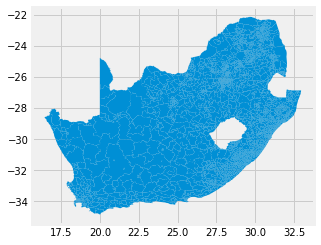

In [37]:
wards_sa.plot()

In [38]:
wards_wc = wards_sa[wards_sa.PROVINCE == "Western Cape"]
print(wards_wc.shape)
wards_wc.head()

(387, 10)


,PROVINCE,CAT_B,MUNICNAME,WARDNO,WARD_ID,WARD_POP,Area,Shape_Leng,Shape_Area,geometry
0,Western Cape,WC011,Matzikama Local Municipality,1,10101001,3197,113.945188,0.730074,0.010829,POLYGON ((18.29086898800006 -31.52614444199997...
1,Western Cape,WC011,Matzikama Local Municipality,2,10101002,3256,467.354973,1.360033,0.044463,POLYGON ((18.22450099700006 -31.56811899799993...
2,Western Cape,WC011,Matzikama Local Municipality,3,10101003,3268,201.121780,0.749417,0.019106,POLYGON ((18.55321699600006 -31.59578699999997...
3,Western Cape,WC011,Matzikama Local Municipality,4,10101004,3110,34.669564,0.335238,0.003297,POLYGON ((18.58101300400006 -31.65973900099993...
4,Western Cape,WC011,Matzikama Local Municipality,5,10101005,3122,541.407537,1.473706,0.051575,POLYGON ((18.51915739400005 -31.66599466499997...


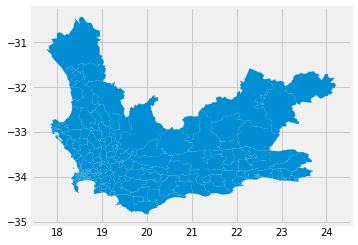

In [39]:
wards_wc.plot()

In [40]:
wards_wc.MUNICNAME.value_counts()

City of Cape Town Metropolitan Municipality    111
Drakenstein Local Municipality                  31
George Local Municipality                       25
Stellenbosch Local Municipality                 22
Breede Valley Local Municipality                21
Mossel Bay Local Municipality                   14
Saldanha Bay Local Municipality                 13
Theewaterskloof Local Municipality              13
Oudtshoorn Local Municipality                   13
Overstrand Local Municipality                   13
Witzenberg Local Municipality                   12
Langeberg Local Municipality                    12
Swartland Local Municipality                    12
Knysna Local Municipality                       10
Hessequa Local Municipality                      8
Matzikama Local Municipality                     8
Beaufort West Local Municipality                 7
Bergrivier Local Municipality                    7
Bitou Local Municipality                         7
Cederberg Local Municipality   

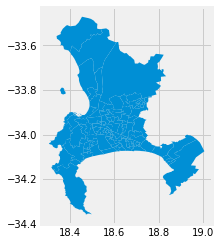

In [41]:
wards_wc[wards_wc.MUNICNAME == "City of Cape Town Metropolitan Municipality"].plot()

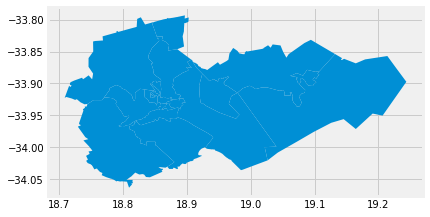

In [42]:
wards_wc[wards_wc.MUNICNAME == "Stellenbosch Local Municipality"].plot()

In [43]:
wards_wc.WARD_ID.value_counts().shape

(387,)

In order to decide which ward number to use for Paarl, Wellington, Worcester and Stellenbosch, we'll sort these wards by largest population and use the largest ward for the region. 

In [44]:
wards_wc[wards_wc.MUNICNAME == "Stellenbosch Local Municipality"].sort_values(by="WARD_POP", ascending=False)

,PROVINCE,CAT_B,MUNICNAME,WARDNO,WARD_ID,WARD_POP,Area,Shape_Leng,Shape_Area,geometry
101,Western Cape,WC024,Stellenbosch Local Municipality,13,10204013,4413,0.381808,0.031418,0.000037,POLYGON ((18.85051526400002 -33.91252070199994...
89,Western Cape,WC024,Stellenbosch Local Municipality,1,10204001,4344,205.461206,0.858205,0.020033,POLYGON ((19.14121000200004 -33.86244000599993...
103,Western Cape,WC024,Stellenbosch Local Municipality,15,10204015,4241,0.265278,0.032074,0.000026,POLYGON ((18.84525600000006 -33.91839899999997...
102,Western Cape,WC024,Stellenbosch Local Municipality,14,10204014,4047,0.275441,0.032303,0.000027,POLYGON ((18.84817048700006 -33.91439770099998...
92,Western Cape,WC024,Stellenbosch Local Municipality,4,10204004,3918,25.633069,0.265953,0.002499,POLYGON ((18.93543399900005 -33.89642099599996...
110,Western Cape,WC024,Stellenbosch Local Municipality,22,10204022,3911,9.096203,0.185839,0.000887,POLYGON ((18.88583699400004 -33.93797199699998...
105,Western Cape,WC024,Stellenbosch Local Municipality,17,10204017,3882,1.607080,0.072561,0.000157,POLYGON ((18.85219558200004 -33.89701577499994...
108,Western Cape,WC024,Stellenbosch Local Municipality,20,10204020,3865,111.007564,0.637657,0.010832,POLYGON ((18.78342908000008 -33.92321871399997...
98,Western Cape,WC024,Stellenbosch Local Municipality,10,10204010,3846,1.892630,0.078943,0.000185,POLYGON ((18.85706700400004 -33.91860399999996...
97,Western Cape,WC024,Stellenbosch Local Municipality,9,10204009,3792,0.709819,0.044432,0.000069,POLYGON ((18.86788245600007 -33.93364953499997...


In [45]:
wards_wc[wards_wc.MUNICNAME == "Drakenstein Local Municipality"].sort_values(by="WARD_POP", ascending=False)

,PROVINCE,CAT_B,MUNICNAME,WARDNO,WARD_ID,WARD_POP,Area,Shape_Leng,Shape_Area,geometry
74,Western Cape,WC023,Drakenstein Local Municipality,17,10203017,5273,21.938436,0.258835,0.002133,POLYGON ((18.96691561100005 -33.64909271699997...
78,Western Cape,WC023,Drakenstein Local Municipality,21,10203021,4453,0.562915,0.041035,0.000055,POLYGON ((18.99937600200008 -33.71902099999994...
88,Western Cape,WC023,Drakenstein Local Municipality,31,10203031,4342,541.072404,1.625037,0.052466,POLYGON ((18.97174038600002 -33.19099632799998...
83,Western Cape,WC023,Drakenstein Local Municipality,26,10203026,4325,0.903259,0.058418,0.000088,POLYGON ((19.00801899400005 -33.73246173199993...
72,Western Cape,WC023,Drakenstein Local Municipality,15,10203015,4317,37.780452,0.486349,0.003676,POLYGON ((18.92763600200004 -33.69161599999995...
65,Western Cape,WC023,Drakenstein Local Municipality,8,10203008,4258,0.153652,0.028615,0.000015,POLYGON ((18.99188544400005 -33.66961349099995...
68,Western Cape,WC023,Drakenstein Local Municipality,11,10203011,4249,4.984785,0.150277,0.000485,POLYGON ((19.00485499900003 -33.65621200099997...
61,Western Cape,WC023,Drakenstein Local Municipality,4,10203004,4244,5.722158,0.123211,0.000557,POLYGON ((18.95907800000003 -33.72686000299996...
70,Western Cape,WC023,Drakenstein Local Municipality,13,10203013,4179,0.669409,0.037836,0.000065,POLYGON ((18.99818777400003 -33.69911093399998...
79,Western Cape,WC023,Drakenstein Local Municipality,22,10203022,4027,3.198932,0.106526,0.000311,POLYGON ((18.98956716000004 -33.70419796499993...


In [46]:
wards_wc[wards_wc.MUNICNAME == "Breede Valley Local Municipality"].sort_values(by="WARD_POP", ascending=False)

,PROVINCE,CAT_B,MUNICNAME,WARDNO,WARD_ID,WARD_POP,Area,Shape_Leng,Shape_Area,geometry
112,Western Cape,WC025,Breede Valley Local Municipality,2,10205002,3861,151.687615,0.758333,0.014708,POLYGON ((19.81990999800007 -33.37691999699996...
131,Western Cape,WC025,Breede Valley Local Municipality,21,10205021,3833,81.419088,0.581923,0.007921,POLYGON ((19.43874306000004 -33.66386324199993...
123,Western Cape,WC025,Breede Valley Local Municipality,13,10205013,3833,6.092040,0.128234,0.000592,POLYGON ((19.46237978200003 -33.65511027199994...
120,Western Cape,WC025,Breede Valley Local Municipality,10,10205010,3692,6.324851,0.126430,0.000615,POLYGON ((19.47053262500003 -33.64710776799996...
111,Western Cape,WC025,Breede Valley Local Municipality,1,10205001,3645,1463.226464,2.155859,0.141812,POLYGON ((20.22450000200007 -33.34597999899995...
129,Western Cape,WC025,Breede Valley Local Municipality,19,10205019,3626,794.239084,1.888106,0.077354,POLYGON ((19.37783100000007 -33.65496900099998...
115,Western Cape,WC025,Breede Valley Local Municipality,5,10205005,3613,353.442801,0.911514,0.034309,POLYGON ((19.53790999800003 -33.42644000099995...
114,Western Cape,WC025,Breede Valley Local Municipality,4,10205004,3612,160.254644,0.765261,0.015540,POLYGON ((19.60104000000007 -33.36853999799996...
128,Western Cape,WC025,Breede Valley Local Municipality,18,10205018,3569,468.854519,1.219760,0.045601,POLYGON ((19.65037999700007 -33.59349999999995...
118,Western Cape,WC025,Breede Valley Local Municipality,8,10205008,3476,7.204209,0.136377,0.000700,POLYGON ((19.49284900000004 -33.64228799699998...


In [47]:
wards_wc[wards_wc.MUNICNAME == "Langeberg Local Municipality"].sort_values(by="WARD_POP", ascending=False)

,PROVINCE,CAT_B,MUNICNAME,WARDNO,WARD_ID,WARD_POP,Area,Shape_Leng,Shape_Area,geometry
133,Western Cape,WC026,Langeberg Local Municipality,2,10206002,3990,15.184311,0.218196,0.001479,POLYGON ((19.88716440800005 -33.79662925799994...
143,Western Cape,WC026,Langeberg Local Municipality,12,10206012,3727,1963.041218,2.788195,0.190766,POLYGON ((20.47562999900003 -33.51343999799997...
138,Western Cape,WC026,Langeberg Local Municipality,7,10206007,3585,412.215149,1.029257,0.040160,POLYGON ((20.13028357700006 -33.75872379199996...
139,Western Cape,WC026,Langeberg Local Municipality,8,10206008,3439,744.502114,1.876477,0.072643,POLYGON ((19.99556234500005 -33.87422981999998...
140,Western Cape,WC026,Langeberg Local Municipality,9,10206009,3277,119.759582,0.531690,0.011659,POLYGON ((20.07772800100003 -33.78409600699996...
134,Western Cape,WC026,Langeberg Local Municipality,3,10206003,3208,2.359332,0.110680,0.000230,POLYGON ((19.88731777300006 -33.77604591499994...
135,Western Cape,WC026,Langeberg Local Municipality,4,10206004,3169,17.787371,0.180407,0.001734,POLYGON ((20.10710424200005 -33.91145485099997...
137,Western Cape,WC026,Langeberg Local Municipality,6,10206006,2984,349.531284,1.020329,0.034014,POLYGON ((19.88198000000006 -33.72342600099995...
136,Western Cape,WC026,Langeberg Local Municipality,5,10206005,2886,722.462108,1.383029,0.070445,POLYGON ((19.70889370500004 -33.84311785199998...
132,Western Cape,WC026,Langeberg Local Municipality,1,10206001,2879,2.518032,0.094463,0.000245,POLYGON ((19.88286699900004 -33.79132100299995...


In [48]:
wards_wc[wards_wc.MUNICNAME == "Swartland Local Municipality"].sort_values(by="WARD_POP", ascending=False)

,PROVINCE,CAT_B,MUNICNAME,WARDNO,WARD_ID,WARD_POP,Area,Shape_Leng,Shape_Area,geometry
44,Western Cape,WC015,Swartland Local Municipality,11,10105011,4011,0.917019,0.071120,0.000089,POLYGON ((18.71162899200004 -33.46239299899997...
43,Western Cape,WC015,Swartland Local Municipality,10,10105010,3906,6.031141,0.143648,0.000585,POLYGON ((18.72717596200005 -33.44366722899997...
42,Western Cape,WC015,Swartland Local Municipality,9,10105009,3723,0.778724,0.039701,0.000076,POLYGON ((18.69974529200005 -33.45970701499994...
40,Western Cape,WC015,Swartland Local Municipality,7,10105007,3706,314.040841,0.896092,0.030495,POLYGON ((18.81527687200003 -33.48304035899997...
41,Western Cape,WC015,Swartland Local Municipality,8,10105008,3691,8.257401,0.171521,0.000801,POLYGON ((18.74647955500006 -33.45234245499995...
35,Western Cape,WC015,Swartland Local Municipality,2,10105002,3626,3.656234,0.117336,0.000353,POLYGON ((18.66913915900005 -33.13622882099997...
45,Western Cape,WC015,Swartland Local Municipality,12,10105012,3521,396.357559,1.261835,0.038437,POLYGON ((18.98370998900003 -33.32936999799995...
39,Western Cape,WC015,Swartland Local Municipality,6,10105006,3468,556.112488,1.507791,0.053818,POLYGON ((18.62792799500005 -33.14673425499996...
38,Western Cape,WC015,Swartland Local Municipality,5,10105005,3393,649.142819,1.982559,0.062877,(POLYGON ((18.07427000200005 -33.4126199999999...
34,Western Cape,WC015,Swartland Local Municipality,1,10105001,3206,455.240026,1.044614,0.043939,POLYGON ((18.59028000200004 -32.90022000399995...


In [49]:
data.locality.value_counts()

CBD                 144
Stellenbosch        133
V & A Waterfront     80
Sea Point            53
Franschhoek          49
Gardens              48
Claremont            47
Bellville            47
Green Point          44
Durbanville          39
Century City         37
Somerset West        37
Kenilworth           37
Paarl                33
Table View           32
Constantia           31
Woodstock            30
Hermanus             28
Observatory          25
Newlands             21
Goodwood             20
Brackenfell          20
De Waterkant         19
Camps Bay            19
Hout Bay             19
Foreshore            18
Rondebosch           16
Robertson            12
Bloubergstrand       12
Tokai                11
                   ... 
Wynberg               7
Sunningdale           7
Crawford              7
Diep River            7
Kalk Bay              7
Pinelands             6
Simon's Town          6
Wellington            6
Fish Hoek             6
Tamboerskloof         5
Muizenberg      

Ward numbers were manually found using http://www.capetown.gov.za/family%20and%20home/meet-the-city/city-council/find-your-councillor-ward-or-subcouncil search tool. 

Since the same suburb can be part of multiple wards, where there was more than one option, a guess was taken as to which ward should be used. Paarl, Wellington and Stellenbosch made use of additional data from http://www.drakenstein.gov.za/drakenstein-zoning-scheme-by-law, https://www.stellenbosch.gov.za/council/ward-profiles and https://www.stellenbosch.gov.za/council/ward-plans/

Darling and Ribeek Kasteel from http://www.swartland.org.za/media/docs/2017/town-planning/SDF_Amendment/Maps/Strategies/Strategy%201.pdf.

Worcester from http://www.bvm.gov.za/bvmweb/images/Maps/BVM%20Wards%20A0.pdf

Hermanus from https://www.hermanus.co.za/demographics

Robertson from https://www.langeberg.gov.za/municipal-documents/municipal-ward-boundaries/cat_view/5-municipal-publications/117-municipal-ward-boundaries/

We'll use the Ward ID rather than the ward number to join data. This is because the ward number resets to 1 for each municipality. If we try to join on this then we'll get conflicts as ward number 1, for example, appears multiple times. the ward ID is unique across all wards though, so if we join on this, we can then bring in the correct ward number as part of the join, for use later.

In [50]:
ward_mapping = {
    "CBD" : "19100015",
    "Malmesbury": "19100011",
    "Stellenbosch" : "10204009",  
    "Neelsie Student Centre": "10204009",
    "V & A Waterfront" : "19100015",                    
    "Sea Point" : "19100054",                          
    "Gardens" : "19100077",                             
    "Franschhoek" : "10204001",                         
    "Claremont" : "19100059",                          
    "Bellville" : "19100010",                          
    "Green Point" : "19100015",                        
    "Durbanville" : "19100021",                        
    "Century City" : "19100055",                        
    "Somerset West" : "19100084",                      
    "Paarl" : "10203017",                              
    "Constantia" : "19100062",                         
    "Table View" : "19100107",                        
    "Woodstock" : "19100015",                          
    "Hermanus" : "10302003",                           
    "Kenilworth" : "19100059",                         
    "Observatory" : "19100053",                        
    "Newlands" : "19100062",                           
    "Camps Bay" : "19100054",                          
    "Brackenfell" : "19100102",                        
    "De Waterkant" : "19100015",                       
    "Foreshore" : "19100015",                           
    "Goodwood" : "19100027",                           
    "Hout Bay" : "19100074",                           
    "Rondebosch" : "19100060",                         
    "Bloubergstrand" : "19100023",                      
    "Robertson" : "10206002",                          
    "Tokai" : "19100071",                              
    "Strand" : "19100085",                             
    "Plattekloof" : "19100001",                        
    "Milnerton" : "19100055",                           
    "Parklands" : "19100107",                           
    "Cape Town International Airport" : "19100106",     
    "Kalk Bay" : "19100064",                            
    "Gordons Bay" : "19100100",                         
    "Plumstead" : "19100063",                           
    "Wynberg" : "19100062",                            
    "Athlone" : "19100060",                             
    "Sunningdale" : "19100023",                         
    "Noordhoek" : "19100069",                           
    "Crawford" : "19100048",                            
    "Wellington" : "10203004",                          
    "Diep River" : "19100073",                          
    "Pinelands" : "19100053",                           
    "Muizenberg"  : "19100064",                          
    "Simon's Town" : "19100061",                        
    "Fish Hoek"  : "19100064",                          
    "Tamboerskloof" : "19100077",                       
    "Zonnebloem"  : "19100015",                         
    "Kuils River" : "19100011",                         
    "Melkbosstrand" : "19100023",                      
    "Rylands" : "19100046",                             
    "Riebeek Kasteel" : "10105012",                      
    "Mowbray" : "19100053",                              
    "Bergvliet" : "19100071",                           
    "Kraaifontein" : "19100101",                        
    "Vredehoek" : "19100077",                           
    "Parow" : "19100010",                               
    "Lakeside" : "19100064",                            
    "Ottery" : "19100063",                              
    "Hanover Park" : "19100047",                         
    "Montague Gardens" : "19100004",                   
    "Mouille Point"  : "19100015",                      
    "Worcester"  : "10205002",                          
    "Darling" : "10105006",                             
    "Maitland" : "19100056",                            
    "Scarborough" : "19100061"                         
}

In [51]:
def match_suburb_with_ward(row):
    return ward_mapping.get(row["locality"])
    
data["ward_id"] = data.apply(match_suburb_with_ward, axis=1)
data.head()

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese,places,region,cuisine_count,place_type,ward_id
0,Moro Gelato,"Desserts, Ice Cream",4.8,Excellent,72,80,1,CBD,Cape Town,-33.924108,...,0,0,0,0,0,None,City Bowl,2,None,19100015
1,Unframed Ice Cream,Ice Cream,4.7,Excellent,104,40,1,Gardens,Cape Town,-33.928691,...,0,0,0,0,0,None,City Bowl,1,None,19100077
2,The Velvet Cake Co.,"Bakery, Desserts",4.6,Excellent,90,165,2,CBD,Cape Town,-33.919300,...,0,0,0,0,0,None,City Bowl,2,None,19100015
3,The Creamery,"Desserts, Ice Cream",4.5,Excellent,389,110,2,Newlands,Cape Town,-33.970286,...,0,0,0,0,0,None,Southern Suburbs,2,None,19100062
4,My Sugar,"Cafe, Patisserie, Bakery, Desserts",4.5,Excellent,197,125,2,Sea Point,Cape Town,-33.921692,...,0,0,0,0,0,None,Atlantic Seaboard,4,None,19100054


In [52]:
data = data.join(wards_wc.set_index('WARD_ID'), on="ward_id")
data.head()

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,ward_id,PROVINCE,CAT_B,MUNICNAME,WARDNO,WARD_POP,Area,Shape_Leng,Shape_Area,geometry
0,Moro Gelato,"Desserts, Ice Cream",4.8,Excellent,72,80,1,CBD,Cape Town,-33.924108,...,19100015,Western Cape,CPT,City of Cape Town Metropolitan Municipality,15,15321,35.375211,0.346716,0.003455,POLYGON ((18.86541799800005 -34.04616599799994...
1,Unframed Ice Cream,Ice Cream,4.7,Excellent,104,40,1,Gardens,Cape Town,-33.928691,...,19100077,Western Cape,CPT,City of Cape Town Metropolitan Municipality,77,17022,21.884528,0.283070,0.002134,POLYGON ((18.42162859000007 -33.91447890999996...
2,The Velvet Cake Co.,"Bakery, Desserts",4.6,Excellent,90,165,2,CBD,Cape Town,-33.919300,...,19100015,Western Cape,CPT,City of Cape Town Metropolitan Municipality,15,15321,35.375211,0.346716,0.003455,POLYGON ((18.86541799800005 -34.04616599799994...
3,The Creamery,"Desserts, Ice Cream",4.5,Excellent,389,110,2,Newlands,Cape Town,-33.970286,...,19100062,Western Cape,CPT,City of Cape Town Metropolitan Municipality,62,16615,44.110018,0.404056,0.004305,POLYGON ((18.45126800000003 -33.96372699899996...
4,My Sugar,"Cafe, Patisserie, Bakery, Desserts",4.5,Excellent,197,125,2,Sea Point,Cape Town,-33.921692,...,19100054,Western Cape,CPT,City of Cape Town Metropolitan Municipality,54,16921,14.852737,0.331852,0.001447,(POLYGON ((18.41515000400005 -33.8991400039999...


In [53]:
data.rename(index=str, columns={"MUNICNAME": "municipality", "WARDNO": "ward_num"}, inplace=True)
data.head()

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,ward_id,PROVINCE,CAT_B,municipality,ward_num,WARD_POP,Area,Shape_Leng,Shape_Area,geometry
0,Moro Gelato,"Desserts, Ice Cream",4.8,Excellent,72,80,1,CBD,Cape Town,-33.924108,...,19100015,Western Cape,CPT,City of Cape Town Metropolitan Municipality,15,15321,35.375211,0.346716,0.003455,POLYGON ((18.86541799800005 -34.04616599799994...
1,Unframed Ice Cream,Ice Cream,4.7,Excellent,104,40,1,Gardens,Cape Town,-33.928691,...,19100077,Western Cape,CPT,City of Cape Town Metropolitan Municipality,77,17022,21.884528,0.283070,0.002134,POLYGON ((18.42162859000007 -33.91447890999996...
2,The Velvet Cake Co.,"Bakery, Desserts",4.6,Excellent,90,165,2,CBD,Cape Town,-33.919300,...,19100015,Western Cape,CPT,City of Cape Town Metropolitan Municipality,15,15321,35.375211,0.346716,0.003455,POLYGON ((18.86541799800005 -34.04616599799994...
3,The Creamery,"Desserts, Ice Cream",4.5,Excellent,389,110,2,Newlands,Cape Town,-33.970286,...,19100062,Western Cape,CPT,City of Cape Town Metropolitan Municipality,62,16615,44.110018,0.404056,0.004305,POLYGON ((18.45126800000003 -33.96372699899996...
4,My Sugar,"Cafe, Patisserie, Bakery, Desserts",4.5,Excellent,197,125,2,Sea Point,Cape Town,-33.921692,...,19100054,Western Cape,CPT,City of Cape Town Metropolitan Municipality,54,16921,14.852737,0.331852,0.001447,(POLYGON ((18.41515000400005 -33.8991400039999...


# Reorder Columns & Export Prepared CSV

In [54]:
col_order = ['name', 'aggregate_rating', 'rating_text', 'votes',
       'average_cost_for_two', 'price_range', 'cuisines', 'cuisine_count', 'has_online_delivery', 'has_table_booking', 
             'places', 'place_type', 'locality', 'municipality', 'region', 'city', 'latitude','longitude', 'ward_id', 'ward_num']
other_cols = [c for c in data.columns if c not in col_order]
data = data[col_order+other_cols]
data = data.drop(["PROVINCE", "CAT_B", "Shape_Leng", "Shape_Area", "Area", "WARD_POP"], axis=1)
data.sample(5)

,name,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,cuisines,cuisine_count,has_online_delivery,has_table_booking,...,Street Food,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese,geometry
234,The Fat Cactus,4.1,Very Good,420,300,4,"Mexican, Finger Food, Tex-Mex",3,0,0,...,0,0,0,0,1,0,0,0,0,POLYGON ((18.42162859000007 -33.91447890999996...
541,Haas Collective,3.9,Good,173,190,2,Cafe,1,0,0,...,0,0,0,0,0,0,0,0,0,POLYGON ((18.86541799800005 -34.04616599799994...
1621,Pig & Swizzle,2.8,Average,7,120,2,Drinks Only,1,0,0,...,0,0,0,0,0,0,0,0,0,POLYGON ((18.50236844900007 -33.95309113399998...
1489,Tribakery,2.3,Poor,34,200,3,Cafe,1,0,0,...,0,0,0,0,0,0,0,0,0,POLYGON ((18.86541799800005 -34.04616599799994...
312,Beefcakes,3.7,Good,99,300,4,"American, Burger",2,0,0,...,0,0,0,0,0,0,0,0,0,POLYGON ((18.86541799800005 -34.04616599799994...


In [55]:
# Order data by rating desc and export to csv
data.sort_values("aggregate_rating", ascending=False, inplace=False).to_csv('datasets/processed/zomato-cape-town-final.csv', 
                                                                            encoding='utf-8-sig', index=False)